# Predictive model: Business Use Case

## Goal

- Using the available [Road Safety Data](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data) create a predictive modeling business use case
- Desired use case: **On-premise forecast of *dangarous* traffic situations**
- Train model capable to predict accident severity "score": Overall accident severity

## Considerations

- Take all available information into account including spatiotemporal, environmental, vehicle
- Important when defining features: 
    - Only features available *before* accident can be used
    - Do not utilize features not to be used in practice, e.g. 
        - due to GDPR (driver properties)
        - busincess-strategic (car model name)

In [1]:
import os
import pandas
import mlflow
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from workflows.helpers.utils import (
    load_yaml,
    infer_catboost_feature_types,
    read_partitioned_pandas_asset
)

from sklearn import set_config
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.model_selection import ShuffleSplit

from catboost import CatBoostRegressor, Pool

set_config(transform_output="pandas")
assets_dir = Path(os.environ["DATA_DIR"]) / "assets"

In [2]:
X = read_partitioned_pandas_asset("accidents_vehicles_casualties_dataset")
y = X.pop("target")

accidents_vehicles_casualties_dataset - downloaded OK, passed checks


## Properties Visualization

<Axes: title={'center': 'Severity score counts'}, xlabel='target', ylabel='Count'>

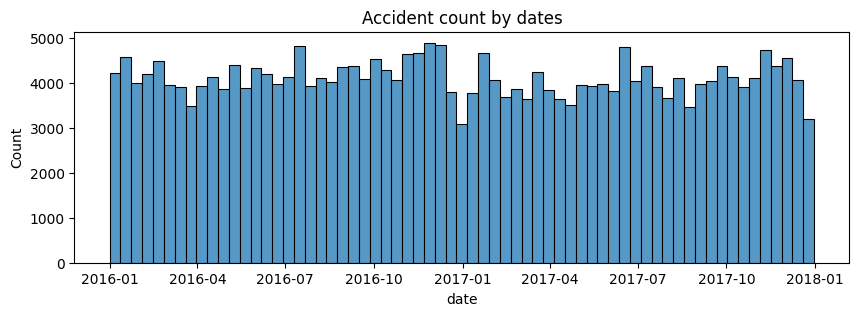

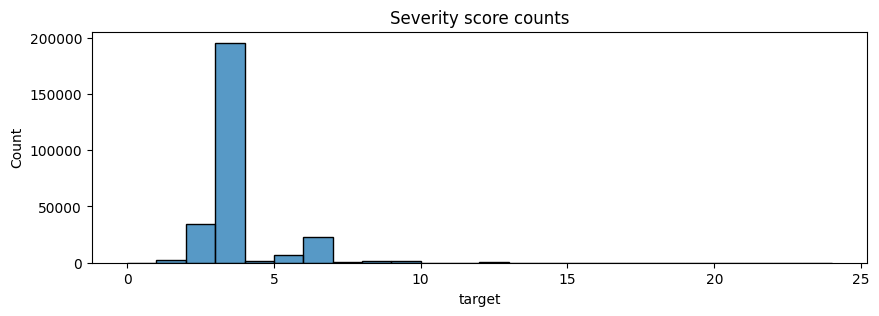

In [3]:
date = pandas.to_datetime(
    X[["accident.year", "accident.month", "accident.day"]]
    .rename(
        columns={
            "accident.year": "year",
            "accident.month": "month",
            "accident.day": "day"
        }
    )
)
date.name = "date"
date = date.to_frame()
date["count"] = 1

# Accident counts
f_count, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Accident count by dates")
sns.histplot(date, x="date", ax=ax)

# Severity score counts
f_score, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Severity score counts")
sns.histplot(y, bins=range(0, int(max(y))), ax=ax)

## Training and logging

- Define model parameters
- Apply training rounds and log params and metrics to tracking server
- Log trained model as model artifact

In [4]:
feat = infer_catboost_feature_types(X)

catboost_init_params = {
    "cat_features": feat["categorical"], 
    "text_features": feat["text"], 
    "od_type": "Iter", 
    "iterations": 400,
    "train_dir": "/tmp/catboost"
}

catboost_fit_params = {
    "early_stopping_rounds": 101,
    "verbose": 100
}

model = CatBoostRegressor(**catboost_init_params)

In [5]:
mlflow.set_registry_uri(os.environ["MLFLOW_TRACKING_URI"])
mlflow.set_experiment("casualty-regression")

2023/08/02 22:32:13 INFO mlflow.tracking.fluent: Experiment with name 'casualty-regression' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket/529410684326183042', creation_time=1691015533597, experiment_id='529410684326183042', last_update_time=1691015533597, lifecycle_stage='active', name='casualty-regression', tags={}>

In [6]:
with mlflow.start_run() as run:
    
    run_id = run.info.run_id

    mlflow.log_figure(f_count, "count_by_date.png")
    mlflow.log_figure(f_score, "score_count.png")
    mlflow.log_params(catboost_init_params)
    mlflow.log_params(catboost_fit_params)
    mlflow.log_param("n_accidents", len(X))
    mlflow.log_param("min_date", date["date"].min())
    mlflow.log_param("max_date", date["date"].max())

    splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train, test in splitter.split(X):
        Xtrain = X.iloc[train]
        ytrain = y.iloc[train]

        data_test = Pool(
            X.iloc[test], 
            y.iloc[test], 
            text_features=feat["text"],
            cat_features=feat["categorical"]
        )

        train, val = next(
            ShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
            .split(Xtrain)
        )

        data_val = Pool(
            X.iloc[val], 
            y.iloc[val], 
            text_features=feat["text"],
            cat_features=feat["categorical"]
        )

        data_train = Pool(
            X.iloc[train], 
            y.iloc[train], 
            text_features=feat["text"],
            cat_features=feat["categorical"]
        )

        model.fit(data_train, eval_set=data_val, **catboost_fit_params)

        ypred = model.predict(data_test)
        
        mae = mean_absolute_error(data_test.get_label(), ypred)
        mse = mean_squared_error(data_test.get_label(), ypred)
        
        mlflow.log_metrics(
            {
                "mae": mae,
                "mse": mse
            }
        )

        # Confusion matrix
        confusion = pandas.DataFrame(
            confusion_matrix(
                data_test.get_label(), 
                np.round(ypred, 0).astype(int)
            )
        )
        confusion.to_csv("/tmp/confusion.csv")
        mlflow.log_artifact("/tmp/confusion.csv")

Learning rate set to 0.205016
0:	learn: 1.1534660	test: 1.1846317	best: 1.1846317 (0)	total: 186ms	remaining: 1m 14s
100:	learn: 0.9955105	test: 1.0297432	best: 1.0297432 (100)	total: 17.7s	remaining: 52.3s
200:	learn: 0.9762063	test: 1.0268503	best: 1.0267758 (198)	total: 39.3s	remaining: 38.9s
300:	learn: 0.9620747	test: 1.0257899	best: 1.0256214 (287)	total: 1m 1s	remaining: 20.3s
399:	learn: 0.9510648	test: 1.0251129	best: 1.0249340 (398)	total: 1m 22s	remaining: 0us

bestTest = 1.02493402
bestIteration = 398

Shrink model to first 399 iterations.


Log model and register new version to registry

In [7]:
example_input = X.sample(n=100)

with mlflow.start_run(run_id=run_id):
    # Fit on complete data and log model artifact
    model.fit(X, y, **catboost_fit_params)
    mlflow.catboost.log_model(
        model, 
        artifact_path="model",
        input_example=example_input
    )

Learning rate set to 0.208445
0:	learn: 1.1740635	total: 373ms	remaining: 2m 28s
100:	learn: 1.0141325	total: 34.8s	remaining: 1m 42s
200:	learn: 0.9955626	total: 1m 1s	remaining: 1m 1s
300:	learn: 0.9830087	total: 1m 28s	remaining: 29.2s
399:	learn: 0.9735050	total: 1m 55s	remaining: 0us


/home/jovyan/.local/lib/python3.11/site-packages/mlflow/models/signature.py:272: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  input_schema = _infer_schema(input_ex)


In [8]:
mlflow.catboost.log_model(
    model, 
    artifact_path="model",
    input_example=example_input
)

/home/jovyan/.local/lib/python3.11/site-packages/mlflow/models/signature.py:272: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  input_schema = _infer_schema(input_ex)
/home/jovyan/.local/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modu

In [9]:
mlflow.register_model(
    model_uri=f"runs:/{run_id}/model",
    name="accident-severity"
)

Successfully registered model 'accident-severity'.
2023/08/02 22:35:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: accident-severity, version 1
Created version '1' of model 'accident-severity'.


<ModelVersion: aliases=[], creation_timestamp=1691015756500, current_stage='None', description='', last_updated_timestamp=1691015756500, name='accident-severity', run_id='8b699c87fafd4cbd9cb4044a25288b7f', run_link='', source='s3://mlflow-bucket/529410684326183042/8b699c87fafd4cbd9cb4044a25288b7f/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>